<a href="https://colab.research.google.com/github/ldm2060/LearningNote/blob/main/DL%202023.6/week6/%E4%BD%9C%E4%B8%9A/hw07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 7 - Bert (Question Answering)**

If you have any questions, feel free to email us at mlta-2022-spring@googlegroups.com



Slide:    [Link](https://docs.google.com/presentation/d/1H5ZONrb2LMOCixLY7D5_5-7LkIaXO6AGEaV2mRdTOMY/edit?usp=sharing)　Kaggle: [Link](https://www.kaggle.com/c/ml2022spring-hw7)　Data: [Link](https://drive.google.com/uc?id=1AVgZvy3VFeg0fX-6WQJMHPVrx3A-M1kb)




## Task description
- Chinese Extractive Question Answering
  - Input: Paragraph + Question
  - Output: Answer

- Objective: Learn how to fine tune a pretrained model on downstream task using transformers

- Todo
    - Fine tune a pretrained chinese BERT model
    - Change hyperparameters (e.g. doc_stride)
    - Apply linear learning rate decay
    - Try other pretrained models
    - Improve preprocessing
    - Improve postprocessing
- Training tips
    - Automatic mixed precision
    - Gradient accumulation
    - Ensemble

- Estimated training time (tesla t4 with automatic mixed precision enabled)
    - Simple: 8mins
    - Medium: 8mins
    - Strong: 25mins
    - Boss: 2.5hrs
  

## Download Dataset

In [ ]:
# Download link 1
#!gdown --id '1AVgZvy3VFeg0fX-6WQJMHPVrx3A-M1kb' --output hw7_data.zip

# Download Link 2 (if the above link fails)
# !gdown --id '1qwjbRjq481lHsnTrrF4OjKQnxzgoLEFR' --output hw7_data.zip

# Download Link 3 (if the above link fails)
# !gdown --id '1QXuWjNRZH6DscSd6QcRER0cnxmpZvijn' --output hw7_data.zip

#!unzip -o hw7_data.zip

# For this HW, K80 < P4 < T4 < P100 <= T4(fp16) < V100
!nvidia-smi

Sun Jul 30 06:41:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install transformers

Documentation for the toolkit:　https://huggingface.co/transformers/

In [ ]:
# You are allowed to change version of transformers or use other toolkits
!pip install transformers==4.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.1 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 41.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 17.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [51 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-310
      creating build/lib.linux-x86_64-cpython-310/tokenizers
      copying py_src/tokenizers/__init__.py -> build/lib.linux-x86_64-cpython-310/tokenizers
      creating build/lib.linux-x86_64-cpython-310/tokenizers/models
      copying py_src/tokenizers/models/__init__.py

## Import Packages

In [ ]:
import json
import numpy as np
import random
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, BertForQuestionAnswering, BertTokenizerFast

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix random seed for reproducibility
def same_seeds(seed):
	  torch.manual_seed(seed)
	  if torch.cuda.is_available():
		    torch.cuda.manual_seed(seed)
		    torch.cuda.manual_seed_all(seed)
	  np.random.seed(seed)
	  random.seed(seed)
	  torch.backends.cudnn.benchmark = False
	  torch.backends.cudnn.deterministic = True
same_seeds(0)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [ ]:
# Change "fp16_training" to True to support automatic mixed precision training (fp16)
fp16_training = False

if fp16_training:
    !pip install accelerate==0.2.0
    from accelerate import Accelerator
    accelerator = Accelerator(fp16=True)
    device = accelerator.device

# Documentation for the toolkit:  https://huggingface.co/docs/accelerate/

## Load Model and Tokenizer






In [ ]:
model = BertForQuestionAnswering.from_pretrained("bert-base-chinese").to(device)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-chinese")

# You can safely ignore the warning message (it pops up because new prediction heads for QA are initialized randomly)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['qa_out

## Read Data

- Training set: 31690 QA pairs
- Dev set: 4131  QA pairs
- Test set: 4957  QA pairs

- {train/dev/test}_questions:
  - List of dicts with the following keys:
   - id (int)
   - paragraph_id (int)
   - question_text (string)
   - answer_text (string)
   - answer_start (int)
   - answer_end (int)
- {train/dev/test}_paragraphs:
  - List of strings
  - paragraph_ids in questions correspond to indexs in paragraphs
  - A paragraph may be used by several questions

In [ ]:
!tree ..

..
├── input
│   └── ml2022spring-hw7
│       ├── hw7_dev.json
│       ├── hw7_test.json
│       └── hw7_train.json
├── lib
│   └── kaggle
│       └── gcp.py
└── working

5 directories, 4 files


In [ ]:
def read_data(file):
    with open(file, 'r', encoding="utf-8") as reader:
        data = json.load(reader)
    return data["questions"], data["paragraphs"]

train_questions, train_paragraphs = read_data("/kaggle/input/ml2022spring-hw7/hw7_train.json")
dev_questions, dev_paragraphs = read_data("/kaggle/input/ml2022spring-hw7/hw7_dev.json")
test_questions, test_paragraphs = read_data("/kaggle/input/ml2022spring-hw7/hw7_test.json")

## Tokenize Data

In [ ]:
# Tokenize questions and paragraphs separately
# 「add_special_tokens」 is set to False since special tokens will be added when tokenized questions and paragraphs are combined in datset __getitem__

train_questions_tokenized = tokenizer([train_question["question_text"] for train_question in train_questions], add_special_tokens=False)
dev_questions_tokenized = tokenizer([dev_question["question_text"] for dev_question in dev_questions], add_special_tokens=False)
test_questions_tokenized = tokenizer([test_question["question_text"] for test_question in test_questions], add_special_tokens=False)

train_paragraphs_tokenized = tokenizer(train_paragraphs, add_special_tokens=False)
dev_paragraphs_tokenized = tokenizer(dev_paragraphs, add_special_tokens=False)
test_paragraphs_tokenized = tokenizer(test_paragraphs, add_special_tokens=False)

# You can safely ignore the warning message as tokenized sequences will be futher processed in datset __getitem__ before passing to model

Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors


## Dataset and Dataloader

In [ ]:
class QA_Dataset(Dataset):
    def __init__(self, split, questions, tokenized_questions, tokenized_paragraphs):
        self.split = split
        self.questions = questions
        self.tokenized_questions = tokenized_questions
        self.tokenized_paragraphs = tokenized_paragraphs
        self.max_question_len = 40
        self.max_paragraph_len = 150

        ##### TODO: Change value of doc_stride #####
        self.doc_stride = 32

        # Input sequence length = [CLS] + question + [SEP] + paragraph + [SEP]
        self.max_seq_len = 1 + self.max_question_len + 1 + self.max_paragraph_len + 1

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        tokenized_question = self.tokenized_questions[idx]
        tokenized_paragraph = self.tokenized_paragraphs[question["paragraph_id"]]

        ##### TODO: Preprocessing #####
        # Hint: How to prevent model from learning something it should not learn

        if self.split == "train":
            # Convert answer's start/end positions in paragraph_text to start/end positions in tokenized_paragraph
            answer_start_token = tokenized_paragraph.char_to_token(question["answer_start"])
            answer_end_token = tokenized_paragraph.char_to_token(question["answer_end"])

            # A single window is obtained by slicing the portion of paragraph containing the answer
            mid = (answer_start_token + answer_end_token) // 2
            paragraph_start = max(0, min(mid - self.max_paragraph_len // 2, len(tokenized_paragraph) - self.max_paragraph_len))
            paragraph_end = paragraph_start + self.max_paragraph_len

            # Slice question/paragraph and add special tokens (101: CLS, 102: SEP)
            input_ids_question = [101] + tokenized_question.ids[:self.max_question_len] + [102]
            input_ids_paragraph = tokenized_paragraph.ids[paragraph_start : paragraph_end] + [102]

            # Convert answer's start/end positions in tokenized_paragraph to start/end positions in the window
            answer_start_token += len(input_ids_question) - paragraph_start
            answer_end_token += len(input_ids_question) - paragraph_start

            # Pad sequence and obtain inputs to model
            input_ids, token_type_ids, attention_mask = self.padding(input_ids_question, input_ids_paragraph)
            return torch.tensor(input_ids), torch.tensor(token_type_ids), torch.tensor(attention_mask), answer_start_token, answer_end_token

        # Validation/Testing
        else:
            input_ids_list, token_type_ids_list, attention_mask_list = [], [], []

            # Paragraph is split into several windows, each with start positions separated by step "doc_stride"
            for i in range(0, len(tokenized_paragraph), self.doc_stride):

                # Slice question/paragraph and add special tokens (101: CLS, 102: SEP)
                input_ids_question = [101] + tokenized_question.ids[:self.max_question_len] + [102]
                input_ids_paragraph = tokenized_paragraph.ids[i : i + self.max_paragraph_len] + [102]

                # Pad sequence and obtain inputs to model
                input_ids, token_type_ids, attention_mask = self.padding(input_ids_question, input_ids_paragraph)

                input_ids_list.append(input_ids)
                token_type_ids_list.append(token_type_ids)
                attention_mask_list.append(attention_mask)

            return torch.tensor(input_ids_list), torch.tensor(token_type_ids_list), torch.tensor(attention_mask_list)

    def padding(self, input_ids_question, input_ids_paragraph):
        # Pad zeros if sequence length is shorter than max_seq_len
        padding_len = self.max_seq_len - len(input_ids_question) - len(input_ids_paragraph)
        # Indices of input sequence tokens in the vocabulary
        input_ids = input_ids_question + input_ids_paragraph + [0] * padding_len
        # Segment token indices to indicate first and second portions of the inputs. Indices are selected in [0, 1]
        token_type_ids = [0] * len(input_ids_question) + [1] * len(input_ids_paragraph) + [0] * padding_len
        # Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]
        attention_mask = [1] * (len(input_ids_question) + len(input_ids_paragraph)) + [0] * padding_len

        return input_ids, token_type_ids, attention_mask

train_set = QA_Dataset("train", train_questions, train_questions_tokenized, train_paragraphs_tokenized)
dev_set = QA_Dataset("dev", dev_questions, dev_questions_tokenized, dev_paragraphs_tokenized)
test_set = QA_Dataset("test", test_questions, test_questions_tokenized, test_paragraphs_tokenized)

train_batch_size = 32

# Note: Do NOT change batch size of dev_loader / test_loader !
# Although batch size=1, it is actually a batch consisting of several windows from the same QA pair
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, pin_memory=True)
dev_loader = DataLoader(dev_set, batch_size=1, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=True)

## Function for Evaluation

In [ ]:
def evaluate(data, output):
    ##### TODO: Postprocessing #####
    # There is a bug and room for improvement in postprocessing
    # Hint: Open your prediction file to see what is wrong

    answer = ''
    max_prob = float('-inf')
    num_of_windows = data[0].shape[1]

    for k in range(num_of_windows):
        # Obtain answer by choosing the most probable start position / end position
        start_prob, start_index = torch.max(output.start_logits[k], dim=0)
        end_prob, end_index = torch.max(output.end_logits[k], dim=0)

        # Probability of answer is calculated as sum of start_prob and end_prob
        prob = start_prob + end_prob

        # Replace answer if calculated probability is larger than previous windows
        if prob > max_prob:
            max_prob = prob
            # Convert tokens to chars (e.g. [1920, 7032] --> "大 金")
            answer = tokenizer.decode(data[0][0][k][start_index : end_index + 1])

    # Remove spaces in answer (e.g. "大 金" --> "大金")
    return answer.replace(' ','')

## Training

In [ ]:
num_epoch = 1
validation = True
logging_step = 100
learning_rate = 2e-4
optimizer = AdamW(model.parameters(), lr=learning_rate)
from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=1000)

if fp16_training:
    model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

model.train()

print("Start Training ...")

for epoch in range(num_epoch):
    step = 1
    train_loss = train_acc = 0

    for data in tqdm(train_loader):
        # Load all data into GPU
        data = [i.to(device) for i in data]

        # Model inputs: input_ids, token_type_ids, attention_mask, start_positions, end_positions (Note: only "input_ids" is mandatory)
        # Model outputs: start_logits, end_logits, loss (return when start_positions/end_positions are provided)
        output = model(input_ids=data[0], token_type_ids=data[1], attention_mask=data[2], start_positions=data[3], end_positions=data[4])

        # Choose the most probable start position / end position
        start_index = torch.argmax(output.start_logits, dim=1)
        end_index = torch.argmax(output.end_logits, dim=1)

        # Prediction is correct only if both start_index and end_index are correct
        train_acc += ((start_index == data[3]) & (end_index == data[4])).float().mean()
        train_loss += output.loss

        if fp16_training:
            accelerator.backward(output.loss)
        else:
            output.loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        step += 1

        ##### TODO: Apply linear learning rate decay #####


        # Print training loss and accuracy over past logging step
        if step % logging_step == 0:
            print(f"Epoch {epoch + 1} | Step {step} | loss = {train_loss.item() / logging_step:.3f}, acc = {train_acc / logging_step:.3f}")
            train_loss = train_acc = 0

    if validation:
        print("Evaluating Dev Set ...")
        model.eval()
        with torch.no_grad():
            dev_acc = 0
            for i, data in enumerate(tqdm(dev_loader)):
                output = model(input_ids=data[0].squeeze(dim=0).to(device), token_type_ids=data[1].squeeze(dim=0).to(device),
                       attention_mask=data[2].squeeze(dim=0).to(device))
                # prediction is correct only if answer text exactly matches
                dev_acc += evaluate(data, output) == dev_questions[i]["answer_text"]
            print(f"Validation | Epoch {epoch + 1} | acc = {dev_acc / len(dev_loader):.3f}")
        model.train()

# Save a model and its configuration file to the directory 「saved_model」
# i.e. there are two files under the direcory 「saved_model」: 「pytorch_model.bin」 and 「config.json」
# Saved model can be re-loaded using 「model = BertForQuestionAnswering.from_pretrained("saved_model")」
print("Saving Model ...")
model_save_dir = "saved_model"
model.save_pretrained(model_save_dir)

Start Training ...


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/991 [00:00<?, ?it/s]

Epoch 1 | Step 100 | loss = 2.251, acc = 0.353
Epoch 1 | Step 200 | loss = 1.065, acc = 0.585
Epoch 1 | Step 300 | loss = 0.893, acc = 0.648
Epoch 1 | Step 400 | loss = 0.819, acc = 0.668
Epoch 1 | Step 500 | loss = 0.708, acc = 0.709
Epoch 1 | Step 600 | loss = 0.659, acc = 0.722
Epoch 1 | Step 700 | loss = 0.604, acc = 0.742
Epoch 1 | Step 800 | loss = 0.571, acc = 0.763
Epoch 1 | Step 900 | loss = 0.503, acc = 0.780
Evaluating Dev Set ...


  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 1 | acc = 0.633
Saving Model ...


## Testing

In [ ]:
print("Evaluating Test Set ...")

result = []

model.eval()
with torch.no_grad():
    for data in tqdm(test_loader):
        output = model(input_ids=data[0].squeeze(dim=0).to(device), token_type_ids=data[1].squeeze(dim=0).to(device),
                       attention_mask=data[2].squeeze(dim=0).to(device))
        result.append(evaluate(data, output))

result_file = "/kaggle/working/result.csv"
with open(result_file, 'w') as f:
	  f.write("ID,Answer\n")
	  for i, test_question in enumerate(test_questions):
        # Replace commas in answers with empty strings (since csv is separated by comma)
        # Answers in kaggle are processed in the same way
		    f.write(f"{test_question['id']},{result[i].replace(',','')}\n")

print(f"Completed! Result is in {result_file}")

Evaluating Test Set ...


  0%|          | 0/4957 [00:00<?, ?it/s]

Completed! Result is in /kaggle/working/result.csv


# 最终结果

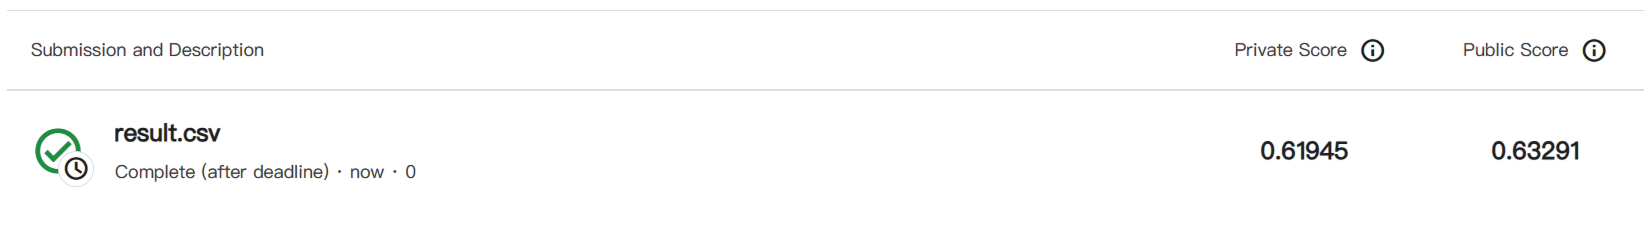